# Script to process flood simualtion results from the validation simualtions (flood event in 2011) and comapare the results with the historical data

In [23]:
import numpy as np
import subprocess
import fiona
import rasterio
from rasterio.mask import mask
import shapely
import shapely.geometry
from shapely.ops import transform

import ogr
import osr
from pyproj import Proj, transform
import geopandas as gpd
import pandas as pd
import gdal
import struct
import matplotlib.pyplot as plt
import os
os.environ["PROJ_LIB"] = "C:/ProgramData/Anaconda3/Library/share"
from mpl_toolkits.basemap import Basemap

from pyproj import Proj, transform
import matplotlib

In [25]:
# define inputs
case = 'validationCase14'

#########################################################
### File name and path for input rasters
## uncomment the 2 lines below to use max height rasters ##
# inRasterName = 'results_grid_height_max.0001.tif'
# inRasterPath = "W:/work/FloodModelling/Thailand_2020/SwiftProjectFiles/" + case + "/" + inRasterName

## uncomment the 2 lines below to use the flood heights at the last time step of the simulation ##
inRasterName = 'results_grid_height.0002.1440.tif'
inRasterPath = 'C:/Users/wee055/Documents/SwiftProjects/Thailand_2020/Results/GeotiffsFromDatFiles/' + case+ '/' + inRasterName

###########################################################

### define required threshold heights
thresholdValues = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]

# path for mask shapefile
#maskShp = "C:/Users/wee055/Documents/SwiftProjects/Thailand_2020/Results/FloodedAreaComparison/Mask/OceanMask.shp"
maskShp = "C:/Users/wee055/Documents/SwiftProjects/Thailand_2020/Results/DesignCase_PostProcessing/Mask/MaskProjected.shp"

# output file name of the masked raster based on inRasterName
maskedRaster = case + '/' + inRasterName[0:-4]+ '_'+'masked.tif'

historicalDataShp = 'C:/Users/wee055/Documents/SwiftProjects/Thailand_2020/Results/FloodedAreaComparison/historicalDataFixed/rd1_20111030_rad_55_0058_0060_clipped_updated.shp'

#historicalDataShp = 'C:/Users/wee055/Documents/SwiftProjects/Thailand_2020/Results/FloodedAreaComparison/historicalDataFixed/rd1_20111030_rad_55_0058_0060_clipped.shp'


In [26]:
#############################################################################
# Make sure all the data is in the same CRS                                #
# Therefore, change the CRS of the mask file to the CRS of the results file #
#############################################################################

# open raster file and get crs
with rasterio.open(inRasterPath) as src:
    target_crs = src.crs

# Convert projection of mask shapefile to projection of the raster
tmp1 = gpd.GeoDataFrame.from_file(maskShp)
tmp1CRS = tmp1.to_crs(target_crs)

tmp2 = gpd.GeoDataFrame.from_file(historicalDataShp)
tmp2CRS = tmp2.to_crs(target_crs)

tmp1CRS.to_file('Mask/MaskProjected.shp')
tmp2CRS.to_file('rd1_20111030_rad_55_0058_0060_Projected.shp')
historicalDataShp = 'rd1_20111030_rad_55_0058_0060_Projected.shp'
print(target_crs)

EPSG:32647


In [27]:
#########################################
### Masking the input(results) raster ###
#########################################

maskShp = 'Mask/MaskProjectedUpdated.shp'
historicalDataShp = 'rd1_20111030_rad_55_0058_0060_Projected.shp'

# read in the mask shapefile
with fiona.open(maskShp, "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
with rasterio.open(inRasterPath) as src:
    # mask the raster with the shapefile geometry
    out_image, out_transform = mask(src, geoms, invert=True)
    out_meta = src.meta.copy()
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

#save the masked raster
with rasterio.open(maskedRaster, "w", **out_meta) as dest:
    dest.write(out_image)

In [28]:
###################################################################
# create new rasters based on flood height thresholds             #
# Loop to create rasters for each of the defined threshold values #
###################################################################

# Input raster properties and values
#ds_temp = gdal.Open(inRasterPath)
ds_temp = gdal.Open(maskedRaster)
xsize = ds_temp.RasterXSize
ysize = ds_temp.RasterYSize
inRasterValues = ds_temp.GetRasterBand(1).ReadAsArray()

# load driver 
driver_tiff = gdal.GetDriverByName('GTiff')
   
# initialize raster grid
#band = np.array()
band = inRasterValues

for t in range(len(thresholdValues)):
    # output raster path
    outRaster = case + '/' + inRasterName[0:-4]+ '_'+'threshold_'+ str(thresholdValues[t]) + 'm.tif'
    
    # Create new raster and set the crs
    ds = driver_tiff.Create(outRaster, xsize = xsize, \
                        ysize = ysize, bands =1,\
                        eType = gdal.GDT_Float32)
    ds.SetGeoTransform(ds_temp.GetGeoTransform())
    ds.SetProjection(ds_temp.GetProjection())
    
    # initialize raster grid
    #band[:][:] = inRasterValues[:][:]
    
    # loop through each grid value to threshold and save to a grid
    for y in range(ysize):
        for x in range(xsize):
            
            if inRasterValues[y][x]>thresholdValues[t]:
                band[y][x] = inRasterValues[y][x]
            
            else:
                band[y][x] = np.NaN
    
    # Write the values to saved raster
    ds.GetRasterBand(1).WriteArray(band)

    ds = None
    
    print('saved '+outRaster)

saved validationCase14/results_grid_height.0002.1440_threshold_0.05m.tif


C:\Users\wee055\.conda\envs\swiftcopy\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in greater


saved validationCase14/results_grid_height.0002.1440_threshold_0.1m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.15m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.2m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.25m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.3m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.35m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.4m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.45m.tif
saved validationCase14/results_grid_height.0002.1440_threshold_0.5m.tif


In [29]:
################################################################
### Total flooded area for each threshold                    ###
### Loop to calculate flooded areas for each threshold value ###
################################################################

#rast = 'validationCase08/results_grid_height_max.0001_masked.tif'
rast = maskedRaster

# open data
data = gdal.Open(rast, gdal.GA_ReadOnly)

# get pixel area from georeference or raster
georef = data.GetGeoTransform()
print(georef)

# area of a pixel
pixelArea = abs(georef[1]*georef[5])
print(pixelArea)

# get the band with data
band = data.GetRasterBand(1).ReadAsArray()

# create empty array to save the area values
resultsArea = [None] * len(thresholdValues)

# conversion: m2 > km2
conversionFactor = 1/1000000

# looping through each threshold case and count the number of pixels corresponding to a threshold
for t in range(len(thresholdValues)):
    # set the pixel count to 0 in each threshold iteration
    pixelCount = 0
    
    for y in range(ysize):
        for x in range(xsize):
            # check threshold and add to pixel count
            if band[y][x]>thresholdValues[t]:
                pixelCount += 1

            else:
                pixelCount += 0
    
    # calculate area based on the number of pixels
    resultsArea[t] = pixelCount*pixelArea*conversionFactor            

print(resultsArea)


(554175.6038411174, 60.0, 0.0, 1741363.1610644213, 0.0, -60.0)
3600.0
[10914.166799999999, 9653.706, 8705.268, 7946.1648, 7320.3804, 6790.625999999999, 6335.7948, 5938.1424, 5588.3844, 5275.638]


In [30]:
### Calculating the intersection area between results and the historical data
###########################################################
## First, rasterizing the historical data shapefile #######
###########################################################

#rast = 'validationCase08/results_grid_height_max.0001_masked.tif'
rast = maskedRaster
outFileHist = case + '/' + 'testRasterize.tif'
# first rasterize the hostorical data shapefile
# ds = gdal.Rasterize('testRasterize.tif',historicalDataShp,burnValues=1)
# print(ds)
# #mask = ds.ReadAsArray()
# ds = None
# gdal.Unlink('testRasterize.tif')

dataSrc = gdal.Open(rast)
shp = ogr.Open(historicalDataShp)

lyr = shp.GetLayer()

driver = gdal.GetDriverByName('GTiff')
dst_ds = driver.Create(
        outFileHist,
        dataSrc.RasterXSize,
        dataSrc.RasterYSize,
        1,
        gdal.GDT_Float32)

dst_ds.SetGeoTransform(dataSrc.GetGeoTransform())
dst_ds.SetProjection(dataSrc.GetProjection())

field = 'Area'

if field is None:
    gdal.RasterizeLayer(dst_ds, [1], lyr, None, options=np.NaN)
else:
    OPTIONS = ['ATTRIBUTE=' + field]
    gdal.RasterizeLayer(dst_ds, [1], lyr, None, options=["ATTRIBUTE=area_km2"])
  

dst_ds = None


# ds = gdal.Rasterize(dst_ds, lyr, xRes=dataSrc.GetGeoTransform()[1], yRes=dataSrc.GetGeoTransform()[5], allTouched=True,
#                     outputBounds=[-120, 30, -100, 50], burnValues=1, 
#                     outputType=gdal.GDT_UInt16)

In [31]:
#####################################################################
### Script to combine rasters into 3 categories ###
## combined raster values -
# raster value = 1 : Intersection of historical data and simulation results (above a certain threshold)
# raster value = 2 : simulation results only (above a certain threshold)
# raster value = 3 : historical data only
###################################################################

# opening historical data raster which was saved in the previous cell
histData = gdal.Open(outFileHist, gdal.GA_ReadOnly)
# get the band with data
histBand = histData.GetRasterBand(1).ReadAsArray()
histBand = np.nan_to_num(histBand)

# opening simulation results file (masked raster)
resultsDataFile = maskedRaster
resultsData = gdal.Open(resultsDataFile, gdal.GA_ReadOnly)
# get the band with data
resultsBand = resultsData.GetRasterBand(1).ReadAsArray()
resultsBand = np.nan_to_num(resultsBand)

# get the dimensions of the rasters
xsize = resultsData.RasterXSize
ysize = resultsData.RasterYSize

# load geotiff driver 
driver_tiff = gdal.GetDriverByName('GTiff')

# names of output rasters to be used in the next cell
outRasterCombinedList = []

# looping through each threshold cases
for t in range(len(thresholdValues)):
#for t in range(1):
    # setting a name for the output raster
    outRasterCombined = case+'/'+inRasterName[0:-4] +'_Combined'+ '_threshold_'+str(thresholdValues[t])+'m.tif'
    outRasterCombinedList.append(outRasterCombined)
    #print(outRasterCombined)
    
    # Create new raster and set the crs
    ds = driver_tiff.Create(outRasterCombined, xsize = xsize, \
                        ysize = ysize, bands =1,\
                        eType = gdal.GDT_Float32)
    ds.SetGeoTransform(resultsData.GetGeoTransform())
    ds.SetProjection(resultsData.GetProjection())

    # initialize output raster band
    #combinedBand = resultsBand
    #combinedBand = [[0 for x in range(xsize)] for y in range(ysize)] 
    combinedBand = np.empty([ysize,xsize])  

    # loop through each grid value to threshold and save to a grid
    for y in range(ysize):
        for x in range(xsize):
            
            # raster value = 3 : historical data only
            if ((histBand[y][x]>0) and (resultsBand[y][x]<=thresholdValues[t])):
                combinedBand[y][x] = 3

            # raster value = 2 : simulation results only (above a certain threshold)
            elif ((resultsBand[y][x]>thresholdValues[t]) and (histBand[y][x]<=0)):
                combinedBand[y][x] = 2
                
            #raster value = 1 : Intersection of historical data and simulation results (above threshold)
            elif ((resultsBand[y][x]>=thresholdValues[t]) and (histBand[y][x]>0)):
                combinedBand[y][x] = 1

            else:
                combinedBand[y][x] = np.NaN

    # Write the values to saved raster
    ds.GetRasterBand(1).WriteArray(combinedBand)   

    # close raster file
    ds = None
    print('saved: ' + outRasterCombined)
    

saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.05m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.1m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.15m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.2m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.25m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.3m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.35m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.4m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.45m.tif
saved: validationCase14/results_grid_height.0002.1440_Combined_threshold_0.5m.tif


In [32]:
#################################################
## Calculating areas from the combined rasters ##
## Areas for the 3 categories of data          ##
#################################################

# create empty array to save the area values
# 3 area arrays for: intersection(1), results only(2) and historical data only (3)
intersectionArea = np.empty(len(thresholdValues))
resultsOnlyArea = np.empty(len(thresholdValues))
histOnlyArea = np.empty(len(thresholdValues))

# loop to go through each threshold combined raster and save areas to the above defined arrays
for t in range(len(thresholdValues)):

    #rast = 'validationCase08/results_grid_height_max.0001_Combined_threshold_'+str(thresholdValues[t])+'m.tif'
    rast = outRasterCombinedList[t]
    
    # open data
    data = gdal.Open(rast, gdal.GA_ReadOnly)

    # get pixel area from georeference or raster
    georef = data.GetGeoTransform()

    # area of a pixel
    pixelArea = abs(georef[1]*georef[5])

    # get the band with data
    band = data.GetRasterBand(1).ReadAsArray()

    # conversion: m2 > km2
    conversionFactor = 1/1000000

    # Define counters for pixel counting (to reset at each iteration)
    pixelCountIntersection = 0
    pixelCountResultsOnly = 0
    pixelCountHistOnly = 0

    # loop through the raster data
    for y in range(ysize):
        for x in range(xsize):
            #raster value = 1 : Intersection of historical data and simulation results (above threshold)
            if (band[y][x]==1):
                pixelCountIntersection += 1

            # raster value = 2 : simulation results only (above a certain threshold)
            elif (band[y][x]==2):
                pixelCountResultsOnly += 1

            # raster value = 3 : historical data only
            elif (band[y][x]==3):
                pixelCountHistOnly += 1

    print(pixelCountIntersection, pixelCountResultsOnly, pixelCountHistOnly )

    # calculate area and store in the relevant array index (according to thresholdValues)
    intersectionArea[t] = pixelCountIntersection*pixelArea*conversionFactor
    resultsOnlyArea[t] = pixelCountResultsOnly*pixelArea*conversionFactor
    histOnlyArea[t] = pixelCountHistOnly*pixelArea*conversionFactor

print(intersectionArea, resultsOnlyArea, histOnlyArea)


1630529 1401184 2069203
1464553 1217032 2235179
1338202 1079928 2361530
1235055 972213 2464677
1149331 884108 2550401
1076261 810024 2623471
1013082 746861 2686650
957663 691821 2742069
908379 643950 2791353
863966 601489 2835766
[5869.9044 5272.3908 4817.5272 4446.198  4137.5916 3874.5396 3647.0952
 3447.5868 3270.1644 3110.2776] [5044.2624 4381.3152 3887.7408 3499.9668 3182.7888 2916.0864 2688.6996
 2490.5556 2318.22   2165.3604] [ 7449.1308  8046.6444  8501.508   8872.8372  9181.4436  9444.4956
  9671.94    9871.4484 10048.8708 10208.7576]


In [33]:
####################################################################
# use geopandas to save the areas calculated in the previous cells #
# to a csv file                                                    #
####################################################################

# create pandas dataframe and define column names
df = pd.DataFrame(columns = ['threshold value (m)','results area (km2)',\
                             'intersection area (km2)', 'results only area (km2)',\
                             'historical data only area (km2)'])

# save area arrays into the columns
df['threshold value (m)'] = thresholdValues
df['results area (km2)'] = resultsArea
df['intersection area (km2)'] = intersectionArea
df['results only area (km2)'] = resultsOnlyArea
df['historical data only area (km2)'] = histOnlyArea

print(df)

# save the dataframe into a csv file
df.to_csv(case + '/'+ inRasterName[0:-4] + 'FloodAreas.csv')

   threshold value (m)  results area (km2)  intersection area (km2)  \
0                 0.05          10914.1668                5869.9044   
1                 0.10           9653.7060                5272.3908   
2                 0.15           8705.2680                4817.5272   
3                 0.20           7946.1648                4446.1980   
4                 0.25           7320.3804                4137.5916   
5                 0.30           6790.6260                3874.5396   
6                 0.35           6335.7948                3647.0952   
7                 0.40           5938.1424                3447.5868   
8                 0.45           5588.3844                3270.1644   
9                 0.50           5275.6380                3110.2776   

   results only area (km2)  historical data only area (km2)  
0                5044.2624                        7449.1308  
1                4381.3152                        8046.6444  
2                3887.7408      

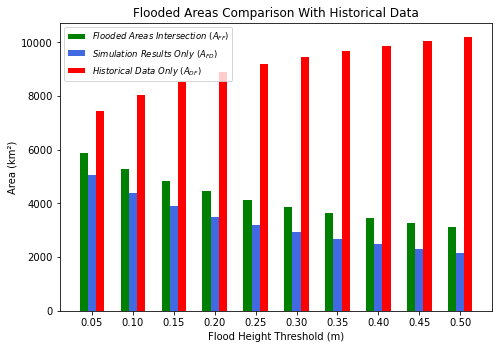

In [34]:
##############################################################################
## Barplot to display flooded areas for the defined thresholds              ##
## 3 types of data: Intersection, Model Flood Only and Historical Data Only ##
##############################################################################
# https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

#X = np.arange(len(thresholdValues))
X = np.linspace(thresholdValues[0],thresholdValues[-1],len(thresholdValues))

# combining the data into one array
data = [intersectionArea,resultsOnlyArea,histOnlyArea]

#plotting the data
# ax.bar(X - 0.01, data[0], color = 'darkmagenta', width = 0.01)
# ax.bar(X + 0.00, data[1], color = 'dodgerblue', width = 0.01)
# ax.bar(X + 0.01, data[2], color = 'orangered', width = 0.01)

ax.bar(X - 0.01, data[0], color = 'g', width = 0.01)
ax.bar(X + 0.00, data[1], color = 'royalblue', width = 0.01)
ax.bar(X + 0.01, data[2], color = 'r', width = 0.01)

# set plot properties
ax.legend(labels=['$Flooded\ Areas\ Intersection\ (A_{FF})$', '$Simulation\ Results\ Only\ (A_{FD})$', '$Historical\ Data\ Only\ (A_{DF})$'],fontsize=8.5)
ax.set_title('Flooded Areas Comparison With Historical Data')
ax.set_ylabel('Area (km²)')
ax.set_xlabel('Flood Height Threshold (m)')
plt.xticks(thresholdValues)

# save the plot into a png
plt.savefig(case+'/'+inRasterName[0:-4]+'AreasComparison.png',bbox_inches='tight', dpi =500)

[0.53782433 0.546152   0.55340366 0.55954012 0.56521538 0.57057179
 0.57563342 0.58058338 0.5851717  0.58955478]
[0.44071544 0.39585381 0.36170242 0.33382283 0.3106525  0.29090242
 0.27382578 0.25884659 0.24552562 0.23352124]


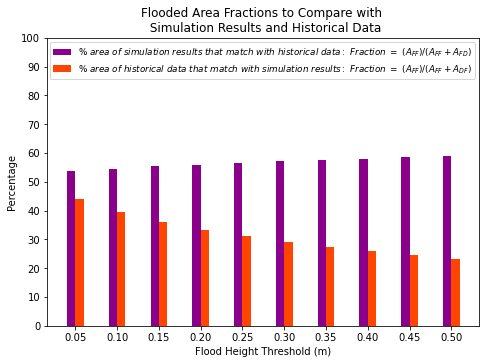

In [35]:
###############################################
######## Plots for additional stats ###########
###############################################

### Plot of area fractions in which the intersection area matches with total results are or total historical area
## % of results which matches with historical data
# resultsPercentage = (g)/(g+b)
resultsPercentage = (intersectionArea/(intersectionArea+resultsOnlyArea))

# histPercentage = (g)/(g+r)
histPercentage = (intersectionArea/(intersectionArea+histOnlyArea))

print(resultsPercentage)
print(histPercentage)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

data = [resultsPercentage*100, histPercentage*100]

ax.bar(X - 0.005, data[0], color = 'darkmagenta', width = 0.01)
ax.bar(X + 0.005, data[1], color = 'orangered', width = 0.01)

plt.xticks(thresholdValues)
plt.yticks(np.linspace(0,1,11)*100)

ax.legend(labels=[ '$\%\ area\ of\ simulation\ results\ that\ match\ with\ historical\ data:\ Fraction\ =\ (A_{FF})/(A_{FF}+A_{FD})$', '$\%\ area\ of\ historical\ data\ that\ match\ with\ simulation\ results:\ Fraction\ =\ (A_{FF})/(A_{FF}+A_{DF})$'],fontsize=8.8)
ax.set_title('Flooded Area Fractions to Compare with \n Simulation Results and Historical Data')
ax.set_ylabel('Percentage')
ax.set_xlabel('Flood Height Threshold (m)')

# save the plot into a png
plt.savefig(case+'/'+inRasterName[0:-4]+'AreaFractions.png',bbox_inches='tight', dpi=500)

[0.48926988 0.4710029  0.45755304 0.44668147 0.43793394 0.4307371
 0.4247296  0.41971498 0.41534866 0.41153801]


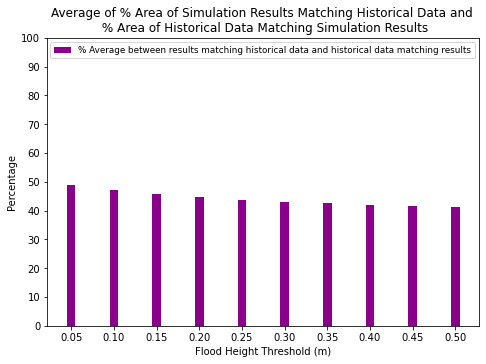

In [36]:
avgPercentage = (resultsPercentage+histPercentage)/2
print(avgPercentage)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X, avgPercentage*100, color = 'darkmagenta', width = 0.01)

plt.xticks(thresholdValues)
plt.yticks(np.linspace(0,1,11)*100)

ax.legend(labels=[ '% Average between results matching historical data and historical data matching results'],fontsize=8.8)
ax.set_title('Average of % Area of Simulation Results Matching Historical Data and \n % Area of Historical Data Matching Simulation Results')
ax.set_ylabel('Percentage')
ax.set_xlabel('Flood Height Threshold (m)')

# save the plot into a png
plt.savefig(case+'/'+inRasterName[0:-4]+'AreaFractionsAverage.png',bbox_inches='tight', dpi=500)

3383 4791 58348.6308


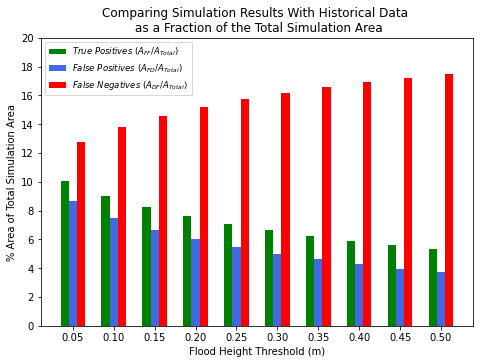

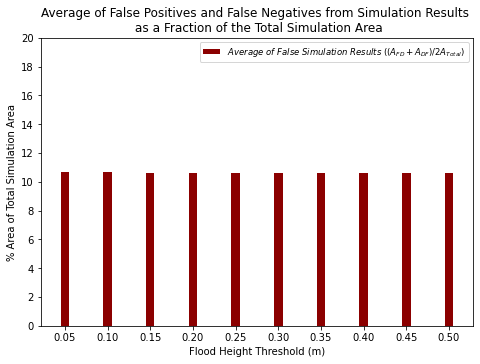

In [37]:
######################################################################
## Comparing data with total simulation area                        ##
## Calculating 4 quantities: True Positives, False Positives        ##
##                           True Negatives, False Negatives        ##
######################################################################

### Script to calculate area
# open sample file
data = gdal.Open(outRasterCombinedList[0], gdal.GA_ReadOnly)

# get geotransform and pixel area
gt = data.GetGeoTransform()
pixelArea = abs(gt[1] * gt[5])

#get the band
band = data.GetRasterBand(1)  

# variable for area
totalArea = 0 

# calculate area (in km^2)
xsize = band.XSize
ysize = band.YSize

# Total area (At)
totalArea = (pixelArea*xsize*ysize)*conversionFactor

print(xsize,ysize,totalArea)

### calculating the required percentages
## True positives = Aff/At
truePositives = intersectionArea/totalArea*100

## False positives = Afd/At
falsePositives = resultsOnlyArea/totalArea*100

## True negativs = Add/At
trueNegatives = (totalArea-(intersectionArea+resultsOnlyArea+histOnlyArea))/totalArea*100

## False negatives = Adf/At
falseNegatives = histOnlyArea/totalArea*100

plotData = [truePositives, falsePositives, trueNegatives, falseNegatives]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(X - 0.01, plotData[0], color = 'g', width = 0.01)
ax.bar(X, plotData[1], color = 'royalblue', width = 0.01)
#ax.bar(X + 0.0075, plotData[2], color = 'r', width = 0.0075)
ax.bar(X + 0.01, plotData[3], color = 'r', width = 0.01)

# set plot properties
ax.legend(labels=['$True\ Positives\ (A_{FF}/A_{Total})$', '$False\ Positives\ (A_{FD}/A_{Total})$', '$False\ Negatives\ (A_{DF}/A_{Total})$'],fontsize=8.5)
ax.set_title('Comparing Simulation Results With Historical Data \n as a Fraction of the Total Simulation Area')
ax.set_ylabel('% Area of Total Simulation Area')
ax.set_xlabel('Flood Height Threshold (m)')
plt.xticks(thresholdValues)
plt.yticks(np.linspace(0,1,11)*20)

# save the plot into a png
plt.savefig(case+'/'+inRasterName[0:-4]+'AccuracyOfResultsAsAFractionOfTotalArea.png',bbox_inches='tight', dpi=500)

##################################################################
### New plot to get average of false positives and false negatives
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

falseResultsAverage = (falsePositives+falseNegatives)/2
ax.bar(X, falseResultsAverage, color = 'darkred', width = 0.01)

# set plot properties
ax.legend(labels=['$Average\ of\ False\ Simulation\ Results\ ((A_{FD}+A_{DF})/2A_{Total})$'],fontsize=8.5)
ax.set_title('Average of False Positives and False Negatives from Simulation Results \n as a Fraction of the Total Simulation Area')
ax.set_ylabel('% Area of Total Simulation Area')
ax.set_xlabel('Flood Height Threshold (m)')
plt.xticks(thresholdValues)
plt.yticks(np.linspace(0,1,11)*20)

# save the plot into a png
plt.savefig(case+'/'+inRasterName[0:-4]+'AccuracyOfResultsAsAFractionOfTotalAreaAverageOfFalse.png',bbox_inches='tight', dpi=500)


[0.40375439 0.35253697 0.31379956 0.2828758  0.25741904 0.23591821
 0.21752107 0.2014686  0.18745071 0.17499109]
[0.55928456 0.60414619 0.63829758 0.66617717 0.6893475  0.70909758
 0.72617422 0.74115341 0.75447438 0.76647876]


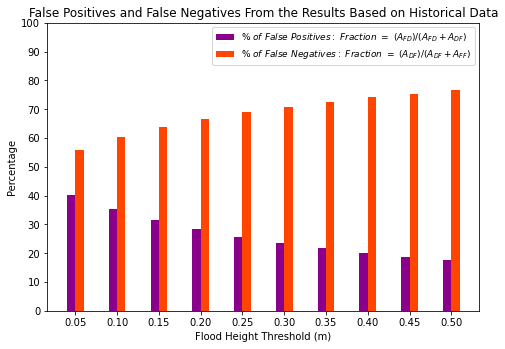

In [38]:
####################################################
######## Plots for additional stats             ####
########### False Positives and False Negatives ####
####################################################

### Plot of area fractions in which the intersection area matches with total results are or total historical area
## false positives = fp/(fp+true negatives)
# false positives = (b)/(b+r)
fp = (resultsOnlyArea/(resultsOnlyArea+histOnlyArea))

# false negatives = fn/(fn + true positives)
# fn = (r)/(r+g)
fn = (histOnlyArea/(histOnlyArea+intersectionArea))

print(fp)
print(fn)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

data = [fp*100, fn*100]

ax.bar(X - 0.005, data[0], color = 'darkmagenta', width = 0.01)
ax.bar(X + 0.005, data[1], color = 'orangered', width = 0.01)

plt.xticks(thresholdValues)
plt.yticks(np.linspace(0,1,11)*100)

ax.legend(labels=[ '$\%\ of\ False\ Positives:\ Fraction\ =\ (A_{FD})/(A_{FD}+A_{DF})$', '$\%\ of\ False\ Negatives:\ Fraction\ =\ (A_{DF})/(A_{DF}+A_{FF})$'],fontsize=9)
ax.set_title('False Positives and False Negatives From the Results Based on Historical Data')
ax.set_ylabel('Percentage')
ax.set_xlabel('Flood Height Threshold (m)')

# save the plot into a png
plt.savefig(case+'/'+inRasterName[0:-4]+'AreaFractions_FalsePositivesFalseNegatives.png',bbox_inches='tight',dpi=500)

saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.05m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.1m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.15m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.2m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.25m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.3m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.35m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.4m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.45m.png
saved validationCase14/results_grid_height.0002.1440_Combined_map_threshold_0.5m.png


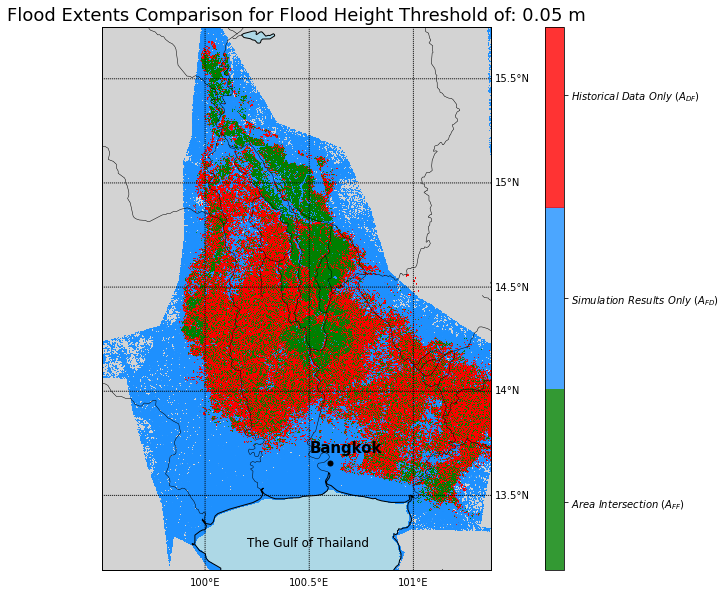

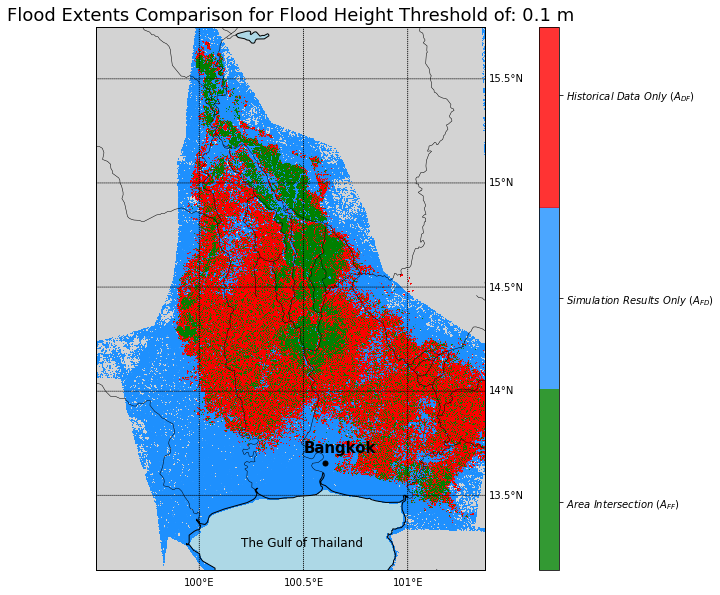

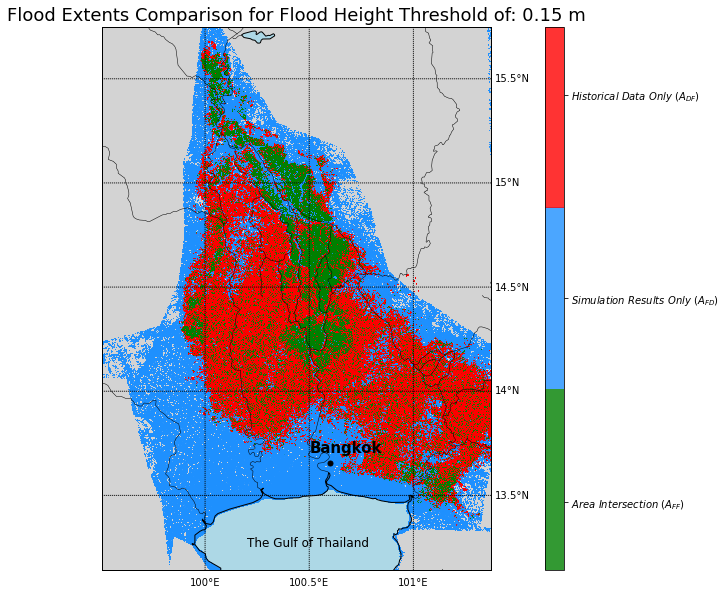

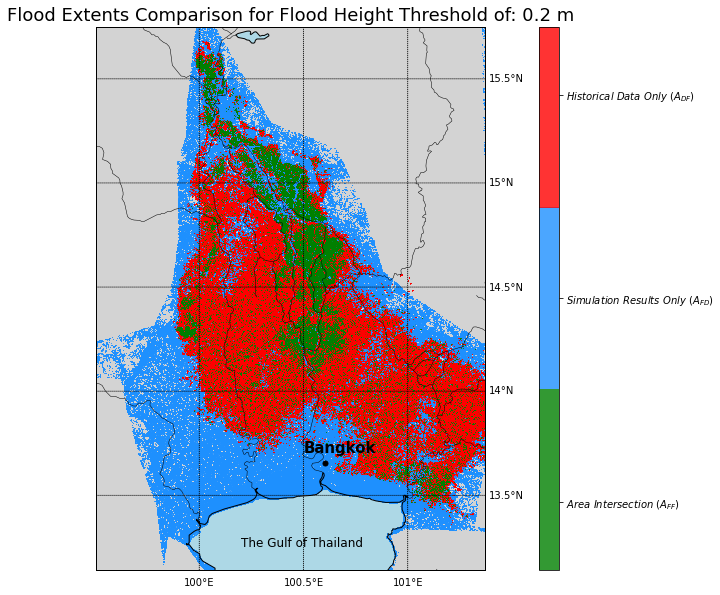

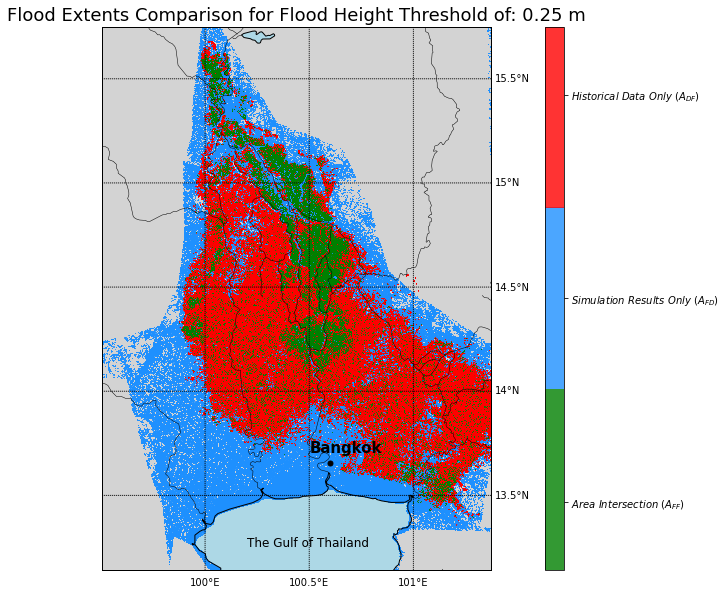

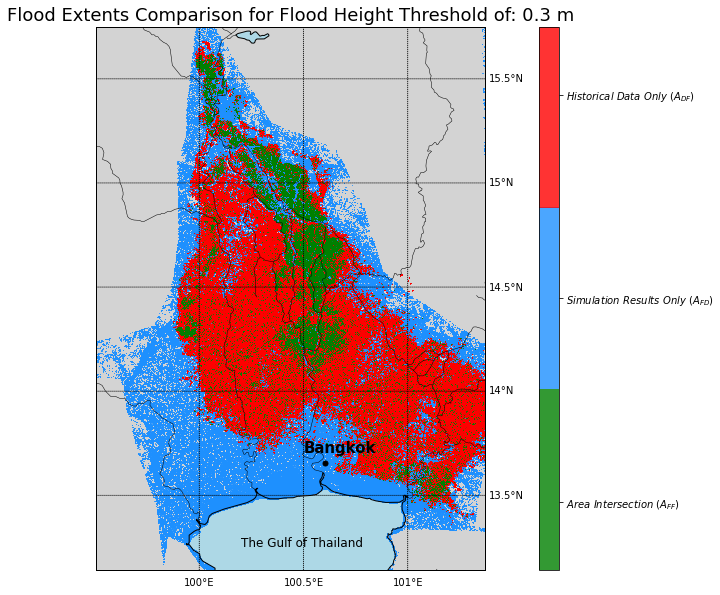

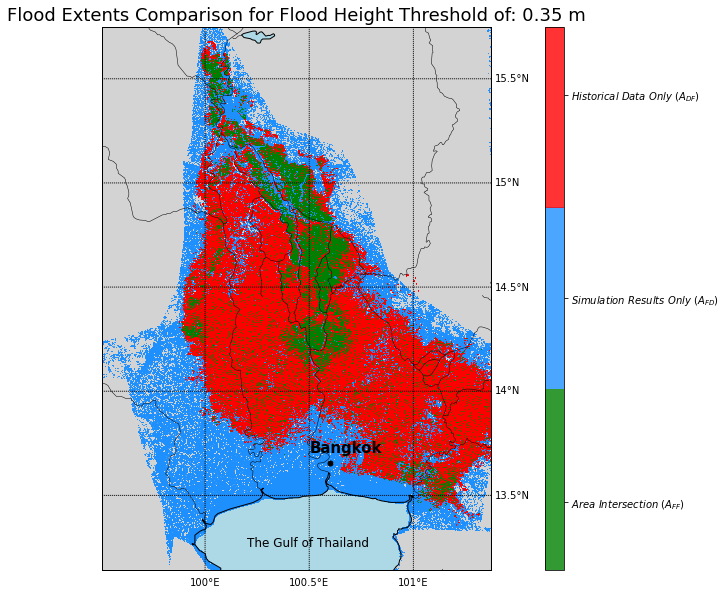

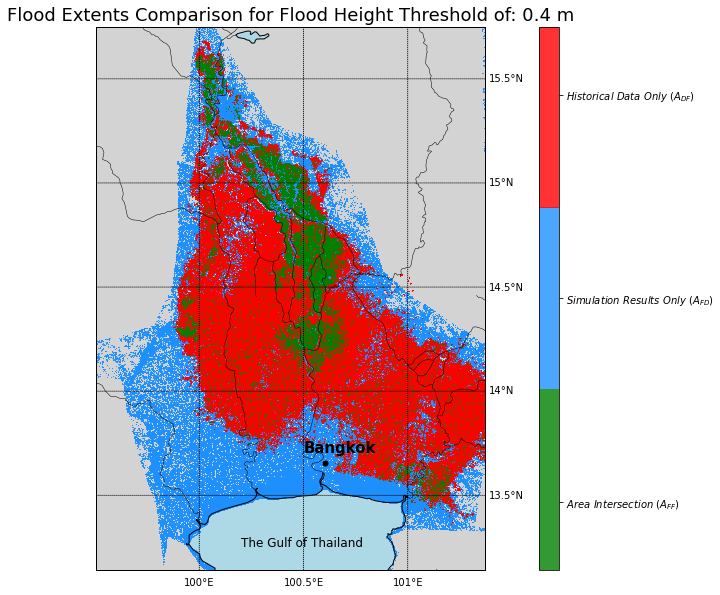

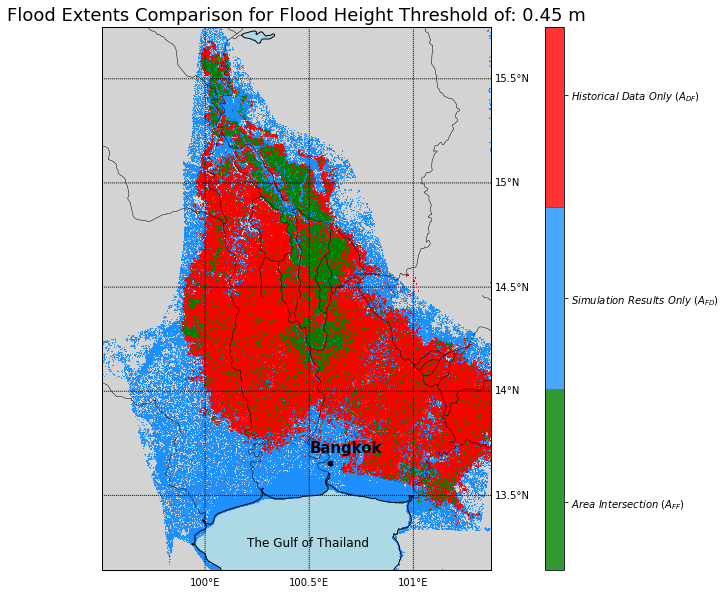

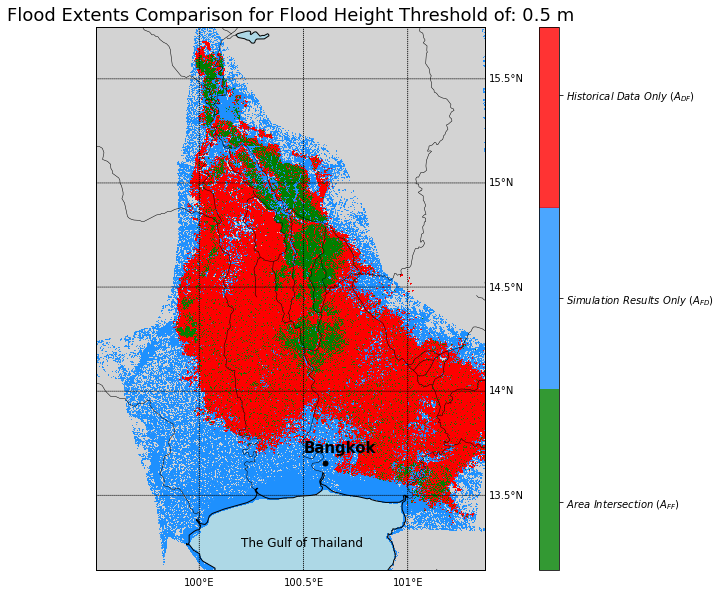

In [39]:
#####################################################
## Script to generate maps of the combined rasters ##
## Individual maps for each raster                 ##
#####################################################

for r in range(len(thresholdValues)):
    # Reading and processing the data
    ds = gdal.Open(outRasterCombinedList[r])

    # read the raster and its properties
    data = ds.ReadAsArray()
    #ulx, xres, xskew, uly, yskew, yres  = src.GetGeoTransform()
    gt = ds.GetGeoTransform()
    proj = ds.GetProjection()
    # x and y resolutions
    xres = gt[1]
    yres = gt[5]
    # upper left x and y coordinates
    ulx = gt[0] + xres * 0.5
    uly = gt[3] - yres * 0.5
    # lower right x and y coordinates based on ul coordinates
    lrx = ulx + (ds.RasterXSize*xres)
    lry = uly + (ds.RasterYSize*yres)
   
    # Setup the source projection - you can also import from epsg, proj4...
    source = osr.SpatialReference()
    source.ImportFromWkt(ds.GetProjection())

    # The target projection (EPSG:4326)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)

    # Create the transform 
    transform = osr.CoordinateTransformation(source, target)

    # Transform the points
    lr = transform.TransformPoint(lrx, lry)
    ul = transform.TransformPoint(ulx,uly)

    # create arrays for the x and y coordinates
    x = np.linspace(ul[1],lr[1], ds.RasterXSize)
    y = np.linspace(ul[0],lr[0], ds.RasterYSize)

    # create a meshgrid with the x and y coordinates
    xx, yy = np.meshgrid(x,y)

    # create a figure
    plt.figure(figsize=(10, 10))

    #create the basemap
    mp = Basemap( llcrnrlon = ul[1],llcrnrlat = lr[0],
                 urcrnrlon = lr[1],
                 urcrnrlat = ul[0], resolution = 'h', epsg = '4326')

    # define color mapping for the 3 values
    cmap = matplotlib.colors.ListedColormap(['g', 'dodgerblue', 'r'])

    # plot the data on the map
    mp.pcolormesh(xx,yy,data,alpha=0.8,cmap = cmap,zorder=2)

    # define meridians(lons) and parallels(lats) to be displayed on the map
    meridians = np.arange(-180, 180, 0.5)
    parallels = np.arange(-90, 90, 0.5)

    # additional map properties
    mp.drawcountries()
    mp.drawcoastlines()
    mp.drawrivers()
    mp.drawmapboundary(linewidth=1.5)
    mp.drawmeridians(meridians,labels=[True,False,False,True])
    mp.drawparallels(parallels,labels=[False,True,True,False])
    mp.drawmapboundary(fill_color='lightblue')
    mp.fillcontinents(color='lightgrey',zorder=1)

    # set customized colorbar
    cbar = mp.colorbar(ticks=[ 1.25,2,2.75],pad=0.75)
    cbar.set_ticklabels(['$Area\ Intersection\ (A_{FF})$','$Simulation\ Results\ Only\ (A_{FD})$','$Historical\ Data\ Only\ (A_{DF})$'])
    #cbar.set_ticklabels(['$A_F$', '$A_D$', '$A_D$'])
    
    # plot Bangkok as a point on the map
    lonBangkok = 100.6018
    latBangkok = 13.6563
    xb,yb = mp(lonBangkok,latBangkok)
    mp.plot(xb,yb,'k.',markersize=10)
    plt.text(xb-0.1,yb+0.05,'Bangkok',fontsize =15, fontweight = 'demi')
    plt.text(xb-0.4, yb-0.4,'The Gulf of Thailand',fontsize=12)

    # set a title and save the figure
    plt.title('Flood Extents Comparison for Flood Height Threshold of: '+str(thresholdValues[r])+' m', fontsize = 18)
    plt.show
    plt.savefig(case+'/'+outRasterCombinedList[r][17:56]+'map_'+outRasterCombinedList[r][56:-4]+'.png',bbox_inches='tight', dpi=500)
    # print output image name
    print('saved '+case+'/'+outRasterCombinedList[r][17:56]+'map_'+outRasterCombinedList[r][56:-4]+'.png')